In [1]:
# Reading the dataset
# Count the number of beatmaps and difficulties

import os
import numpy as np
import rosu_pp_py as osu
import pandas as pd

def count_beatmaps():
    beatmaps_count = 0
    difficulties_count = 0
    for root, dirs, files in os.walk("dataset/beatmaps"):
        # The number of top-level folders corresponds to the number of beatmaps
        beatmaps_count += len(dirs)
        # The number of .osu files (in all subfolders) corresponds to the number of difficulties
        difficulties_count += len([name for name in files if name.endswith(".osu")])
    return beatmaps_count, difficulties_count

beatmaps_count, difficulties_count = count_beatmaps()
print("Beatmaps: ", beatmaps_count)
print("Difficulties: ", difficulties_count)

# Save path to beatmap .osu files in a list, respecting the folder structure
# e.g. "dataset/beatmaps/beatmap1/difficulty1.osu". Every beatmap gets a list of paths to its difficulties

def get_beatmap_paths():
    beatmap_paths = []
    # Respect the folder structure
    for root, dirs, files in os.walk("dataset/beatmaps"):
        for dir in dirs:
            beatmap_path = []
            for root, dirs, files in os.walk(os.path.join("dataset/beatmaps", dir)):
                for file in files:
                    if file.endswith(".osu"):
                        beatmap_path.append(os.path.join(root, file))
            beatmap_paths.append(beatmap_path)
    
    return beatmap_paths

beatmaps = get_beatmap_paths()

Beatmaps:  356
Difficulties:  1718


In [2]:
# Prepare the dataset
# Read metadata from .osu files

def read_metadata(beatmaps : list[list[str]]):
    metadata = {}
    for difficulty in beatmaps:
        for file in difficulty:
            with open(file, "r", encoding="utf-8") as f:
                lines = f.readlines()
                for line in lines:
                    if line.startswith("Title:"):
                        title = line.split(":")[1].strip()
                    elif line.startswith("Artist:"):
                        artist = line.split(":")[1].strip()
                    elif line.startswith("Version:"):
                        version = line.split(":")[1].strip()
                metadata[title] = {"artist": artist, "version": version}
    return metadata

map = osu.Beatmap(path = beatmaps[0][0])
perf = osu.Performance()
attr = perf.calculate(map)
max_attrs = perf.calculate(attr)

print("AR", max_attrs.difficulty.ar)
print("Star Rating", max_attrs.difficulty.stars)
print("PP", max_attrs.pp)
print("BPM", map.bpm)
print("Song", beatmaps[0][0])

AR 9.800000190734863
Star Rating 8.077242505421664
PP 834.5441923076489
BPM 190.0002850004275
Song dataset/beatmaps/1003201 Ata - Euphoria (evilxmaniac)/Ata - Euphoria (evilxmaniac) [Ciyus Miapah's Ultimate Power].osu


In [ ]:
# Create a pandas DataFrame
# Each song has multiple difficulties

# First, define a function which extracts relative time and space distances as well as direction changes between each hit object
# Differentiate between hit objects and sliders by checking the number of coordinates in the line; also give sliders an identifier (boolean)

import time


def extract_and_convert_hit_objects(beatmapPath : str):
    time_diffs = []
    space_diffs = []
    direction_diffs = []
    # Types: jump, slider, spinner
    types = []
    
    # Timing points
    # 0: offset, 1: milliseconds per beat, 2: meter, 3: sample set, 4: sample index, 5: volume, 6: inherited, 7: kiai
    # Convert this to: start time, end time, bpm, slider velocity (in percent)
    timing_points = []
    
    if beatmapPath is None or beatmapPath == "" or not os.path.exists(beatmapPath) or not beatmapPath.endswith(".osu"): raise ValueError("Invalid beatmap path")

    def hit_type_encoder(hit_type : int):
        # 0: hit circle, 1: slider, 2: spinner
        if hit_type & 1: return 0
        if hit_type & 2: return 1
        if hit_type & 8: return 2
        
    def bpm_sliderVelocity_from_timestamp(timestamp : int, timing_points : list):
        bpm = slider_velocity = None
        for timing_point in timing_points:
            # Sanity checks
            if type(timing_point[1]) != float: raise ValueError(f"Invalid timing point {timing_point}")
            if type(timing_point[0]) != float: raise ValueError(f"Invalid timing point {timing_point}")
            if type(timestamp) != float: raise ValueError(f"Invalid timestamp {timestamp}")
            
            if timestamp >= timing_point[0] and timestamp <= timing_point[1]:
                bpm = timing_point[2]
                slider_velocity = timing_point[3]
                break
            
        if bpm is None or slider_velocity is None: raise ValueError(f"Timestamp not in timing points. Timestamp: {timestamp}, Timing points: {timing_points}")
        return bpm, slider_velocity
    
    with open(beatmapPath, "r", encoding="utf-8") as f:
        lines = f.readlines()
        for line in lines:
            # Extract title, artist and version
            if line.startswith("[Metadata]"):
                for i, metadata_line in enumerate(lines[lines.index(line) + 1:]):
                    if metadata_line == "\n":
                        break
                    if metadata_line.startswith("Title:"):
                        title = metadata_line.split(":")[1].strip()
                    elif metadata_line.startswith("Artist:"):
                        artist = metadata_line.split(":")[1].strip()
                    elif metadata_line.startswith("Version:"):
                        version = metadata_line.split(":")[1].strip()
            
            # Extract timing points
            if line.startswith("[TimingPoints]"):
                timing_point_lines = lines[lines.index(line) + 1:]
                # Cut off lines after timing points (until beginning of hit objects)
                # timing_point_lines = timing_point_lines[:timing_point_lines.index("[Colours]\n")]
                
                for i, timing_point in enumerate(timing_point_lines):
                    if timing_point == "\n":
                        break
                    timing_point = timing_point.split(",")
                    if len(timing_points) == 0:
                        start_time = 0.
                    else:
                        start_time = float(timing_point[0])
                    
                    if float(timing_point[1]) < 0:
                        # Inherited timing point / slider velocity
                        # Take the previous timing point's bpm (there should be at least one, since the first timing point is always a non-inherited one)
                        if i == 0 or len(timing_points) == 0:
                            # First timing point is a non-inherited one. Assume that the bpm measure comes after that
                            continue

                        bpm = timing_points[-1][2]
                        slider_velocity = -float(timing_point[1]) / 100
                        
                        if timing_point_lines[i + 1] == "\n":
                            # This is the last timing point (last line is always empty. Second last line is the last hit object)
                            end_time = float(lines[-1].split(",")[2]) + 1
                        else:
                            end_time = float(timing_point_lines[i + 1].split(",")[0])
                        
                        timing_points.append([start_time, end_time, bpm, slider_velocity])
                    else:
                        # Non-inherited timing point
                        bpm = float(timing_point[1])
                        slider_velocity = 1
                        
                        if timing_point_lines[i + 1] == "\n":
                            # This is the last timing point (last line is always empty. Second last line is the last hit object)
                            end_time = float(lines[-1].split(",")[2]) + 1
                        else:
                            end_time = float(timing_point_lines[i + 1].split(",")[0])
                        
                        timing_points.append([start_time, end_time, bpm, slider_velocity])
            
            # Extract hit objects
            if line.startswith("[HitObjects]"):
                hit_objects = lines[lines.index(line) + 1:]
                
                # Initialize variables
                # Determine the relation between hit objects. The hit type of the previous object determines whether the move is a jump or a slider-hold
                x_prev = int(hit_objects[0].split(",")[0])
                y_prev = int(hit_objects[0].split(",")[1])
                time_prev = 0
                hit_type_prev = 0
                
                for hit_object in hit_objects:
                    if hit_object == "\n":
                        continue
                    hit_object = hit_object.split(",")
                    x = float(hit_object[0])
                    y = float(hit_object[1])
                    time = float(hit_object[2])
                    hit_type = hit_type_encoder(int(hit_object[3]))
                    
                    if hit_type == 0:
                        # Current object is a hit circle
                        time_diffs.append(time - time_prev)
                        space_diffs.append(np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2))
                        
                        # Calculate direction change, but check for division by zero (if hit objects are at the same position)
                        if space_diffs[-1] == 0:
                            direction_diffs.append(0)
                        else:
                            direction_diffs.append(np.arctan2(y - y_prev, x - x_prev))
                        # Jump
                        types.append(hit_type_prev)
                    elif hit_type == 1:
                        # Current object is a slider
                        # Two calculations are needed. The first move is a jump (either from a slider-end or a hit circle)
                        # The second move is the slider movement itself
                        # For linear sliders, one additional point is given
                        # For perfect circles, the slider has two additional points
                        # For Bezier curves, the number of points can be arbitrary
                        # FIRST ROUGH IMPLEMENTATION: Approximate each slider part as a straight line
                        
                        time_diffs.append(time - time_prev)
                        space_diffs.append(np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2))
                        
                        # Calculate direction change, but check for division by zero (if hit objects are at the same position)
                        if space_diffs[-1] == 0:
                            direction_diffs.append(0)
                        else:
                            direction_diffs.append(np.arctan2(y - y_prev, x - x_prev))
                        # Jump (from slider-end or hit circle)
                        types.append(hit_type_prev)
                        
                        # Now calculate the slider movement(s)
                        type_of_slider = hit_object[5][0]
                        # Rare case: The slider has no additional points. End the beatmap after this slider
                        # This slider has only the letter-tag and no coordinates
                        if len(hit_object[5]) == 1:
                            # End beatmap
                            break
                        if type_of_slider == "L":
                            # Linear slider
                            # Format: ...,L|x1:y1,...
                            # The slider has one additional point
                            coordinates = hit_object[5].split("|")[1]
                            x_end = int(coordinates.split(":")[0])
                            y_end = int(coordinates.split(":")[1])
                            # Calculate time end from slider velocity and pixel distance
                            pixel_distance = float(hit_object[7])
                            bpm, slider_velocity = bpm_sliderVelocity_from_timestamp(time, timing_points)
                            time_end = time + float(pixel_distance / (60000 * slider_velocity / bpm))
                            time_diffs.append(time_end - time)
                            space_diffs.append(np.sqrt((x_end - x) ** 2 + (y_end - y) ** 2))
                            if space_diffs[-1] == 0:
                                direction_diffs.append(0)
                            else:
                                direction_diffs.append(np.arctan2(y_end - y, x_end - x))
                            # Slider
                            types.append(1)
                        elif type_of_slider == "P":
                            # Perfect circle slider
                            # Format: ...,P|x1:y1|x2:y2,...
                            # The slider has two additional points
                            coordinates = hit_object[5].split("|")[1:]
                            for i, coord in enumerate(coordinates):
                                x_end = int(coord.split(":")[0])
                                y_end = int(coord.split(":")[1])
                                # Calculate time end from slider velocity and pixel distance
                                pixel_distance = float(hit_object[7])
                                bpm, slider_velocity = bpm_sliderVelocity_from_timestamp(time, timing_points)
                                time_end = time + float(pixel_distance / (60000 * slider_velocity / bpm))
                                time_diffs.append(time_end - time)
                                space_diffs.append(np.sqrt((x_end - x) ** 2 + (y_end - y) ** 2))
                                if space_diffs[-1] == 0:
                                    direction_diffs.append(0)
                                else:
                                    direction_diffs.append(np.arctan2(y_end - y, x_end - x))
                                # Slider
                                types.append(1)
                        elif type_of_slider == "B":
                            # Bezier curve slider
                            # Format: ...,B|x1:y1|x2:y2|x3:y3,...
                            # The slider has an arbitrary number of additional points
                            coordinates = hit_object[5].split("|")[1:]
                            for i, coord in enumerate(coordinates):
                                x_end = int(coord.split(":")[0])
                                y_end = int(coord.split(":")[1])
                                # Calculate time end from slider velocity and pixel distance
                                pixel_distance = float(hit_object[7])
                                bpm, slider_velocity = bpm_sliderVelocity_from_timestamp(time, timing_points)
                                time_end = time + float(pixel_distance / (100 * slider_velocity / bpm))
                                time_diffs.append(time_end - time)
                                space_diffs.append(np.sqrt((x_end - x) ** 2 + (y_end - y) ** 2))
                                if space_diffs[-1] == 0:
                                    direction_diffs.append(0)
                                else:
                                    direction_diffs.append(np.arctan2(y_end - y, x_end - x))
                                # Slider
                                types.append(1)
                    elif hit_type == 2:
                        # Current object is a spinner
                        # Spinners are not considered in this analysis
                        pass
                    
                    x_prev = x
                    y_prev = y
                    time_prev = time
                    hit_type_prev = hit_type
                return title, artist, version, time_diffs, space_diffs, direction_diffs, types, timing_points

def test_extract_and_convert_hit_objects():
    # Test function        
    _, _, _, time_diffs, space_diffs, direction_diffs, types, timing_points = extract_and_convert_hit_objects(beatmaps[0][0])

    time_diffs = np.array(time_diffs)
    space_diffs = np.array(space_diffs)
    direction_diffs = np.array(direction_diffs)
    types = np.array(types)
    timing_points = np.array(timing_points)

    print("Time diffs: ", time_diffs)
    print("Space diffs: ", space_diffs)
    print("Direction diffs: ", direction_diffs)
    print("types: ", types)
    print("Timing points: ", timing_points)

    # Print lengths
    print("Time diffs: ", len(time_diffs))
    print("Space diffs: ", len(space_diffs))
    print("Direction diffs: ", len(direction_diffs))
    print("types: ", len(types))
    print("Timing points: ", len(timing_points))

    # Print min, max, avg
    print("Time diffs min: ", np.min(time_diffs), "max: ", np.max(time_diffs), "avg: ", np.mean(time_diffs))
    print("Space diffs min: ", np.min(space_diffs), "max: ", np.max(space_diffs), "avg: ", np.mean(space_diffs))
    print("Direction diffs min: ", np.min(direction_diffs), "max: ", np.max(direction_diffs), "avg: ", np.mean(direction_diffs))

# Write everything into a pandas dataframe
# Each song has multiple difficulties

def create_dataframe(beatmaps : list[list[str]]):
    data = []
    length = len(beatmaps)
    for i, beatmap in enumerate(beatmaps):
        for difficulty in beatmap:
            print(f"Currently processing {i}/{length}: ", difficulty)
            title, artist, version, time_diffs, space_diffs, direction_diffs, types, timing_points = extract_and_convert_hit_objects(difficulty)
            data.append([title, artist, version, time_diffs, space_diffs, direction_diffs, types, timing_points])
        # print("Beatmaps processed: ", i + 1, "/", length)
    return pd.DataFrame(data, columns = ["Title", "Artist", "Version", "Time Diffs", "Space Diffs", "Direction Diffs", "Type", "Timing Points"])

df = create_dataframe(beatmaps)
df

In [17]:
df

,Title,Artist,Version,Time Diffs,Space Diffs,Direction Diffs,Type,Timing Points
0,Euphoria,Ata,Ciyus Miapah's Ultimate Power,"[502.0, 1184.2105263157912, 1184.2105263157912...","[0.0, 45.254833995939045, 91.30169768410661, 1...","[0, -0.7853981633974483, -0.5028432109278609, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0.0, 502.0, 315.789473684211, 1], [502.0, 20..."
1,Euphoria,Ata,Juggernaut 285bpm Tap jumps,"[171818.0, 0.5921052631456405, 316.0, 0.394736...","[0.0, 77.6659513557904, 169.75276139138356, 77...","[0, 0.20749622643520266, 0.6010737544977494, -...","[0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, ...","[[0.0, 502.0, 315.789473684211, 1], [502.0, 20..."
2,Euphoria,Ata,Gate Guardian Deathstream + Technical Stream,"[60660.0, 79.0, 79.0, 79.0, 79.0, 79.0, 79.0, ...","[0.0, 40.0, 40.792156108742276, 40.79215610874...","[0, 2.498091544796509, 2.9441970937399122, -2....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0.0, 502.0, 315.789473684211, 1], [502.0, 20..."
3,Euphoria,Ata,Gate Guardian Deathstream,"[60660.0, 79.0, 79.0, 79.0, 79.0, 79.0, 79.0, ...","[0.0, 40.0, 40.792156108742276, 40.79215610874...","[0, 2.498091544796509, 2.9441970937399122, -2....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0.0, 502.0, 315.789473684211, 1], [502.0, 20..."
4,Euphoria,Ata,King's & Elite Soldier Deathstream + Technical...,"[222344.0, 1.4210526315728202, 1.4210526315728...","[0.0, 54.405882034941776, 144.22205101855957, ...","[0, 2.843093722003614, -3.0860941483440762, 0,...","[0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0.0, 502.0, 315.789473684211, 1], [502.0, 20..."
...,...,...,...,...,...,...,...,...
1713,Axium Crisis,ak+q,Platter,"[4236.0, 0.9411764705873793, 0.941176470587379...","[150.94369811290565, 57.688820407423826, 97.32...","[0.5585993153435624, -0.5880026035475676, -1.7...","[2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, ...","[[0.0, 11613.0, 352.941176470588, 1], [11613.0..."
1714,Axium Crisis,ak+q,Rain,"[4103.0, 0.1323529411765776, 133.0, 1.05882352...","[143.10835055998655, 32.0, 266.2930716334918, ...","[-2.677945044588987, -1.5707963267948966, 0.57...","[2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[[0.0, 11613.0, 352.941176470588, 1], [11613.0..."
1715,Axium Crisis,ak+q,Salad,"[4236.0, 1.2352941176468448, 1.235294117646844...","[101.19288512538814, 50.59644256269407, 195.30...","[0.3217505543966422, -1.8925468811915387, -2.5...","[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0.0, 11613.0, 352.941176470588, 1], [11613.0..."
1716,Axium Crisis,ak+q,Vicious Labyrinth,"[4103.0, 0.13970588235315518, 133.0, 1.1176470...","[90.50966799187809, 32.0, 249.92798962901293, ...","[-0.7853981633974483, 0.0, 2.4468543773930898,...","[2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, ...","[[0.0, 11657.0, 352.941176470588, 1], [11657.0..."


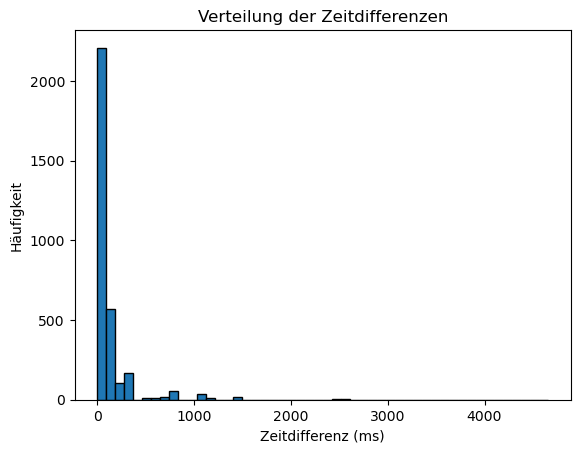

In [18]:
import matplotlib.pyplot as plt

# Beispiel: Histogramm der Zeitdifferenzen
plt.hist(df['Time Diffs'][0], bins=50, edgecolor='black')
plt.title('Verteilung der Zeitdifferenzen')
plt.xlabel('Zeitdifferenz (ms)')
plt.ylabel('Häufigkeit')
plt.show()


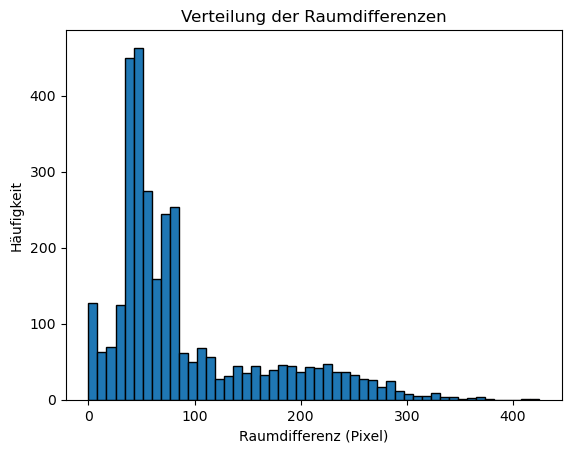

In [19]:
# Beispiel: Histogramm der Raumdifferenzen
plt.hist(df['Space Diffs'][0], bins=50, edgecolor='black')
plt.title('Verteilung der Raumdifferenzen')
plt.xlabel('Raumdifferenz (Pixel)')
plt.ylabel('Häufigkeit')
plt.show()


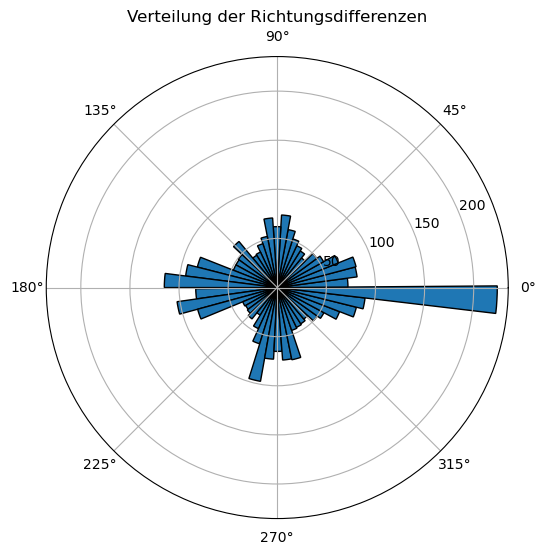

In [20]:
# Beispiel: Polar Histogramm der Richtungsdifferenzen
plt.figure(figsize=(8, 6))
ax = plt.subplot(111, polar=True)
ax.hist(df['Direction Diffs'][0], bins=50, edgecolor='black')
ax.set_title('Verteilung der Richtungsdifferenzen')
plt.show()


In [26]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

data = df

# Vorbereitung der Daten für das Clustering
features = list(zip(data['Time Diffs'][0], data['Space Diffs'][0], data['Direction Diffs'][0]))
kmeans = KMeans(n_clusters=5)
kmeans.fit(features)
labels = kmeans.labels_

# 3D-Plot der Cluster
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data['Time Diffs'][0], data['Space Diffs'][0], data['Direction Diffs'][0], c=labels, cmap='viridis')
ax.set_xlabel('Zeitdifferenz (ms)')
ax.set_ylabel('Raumdifferenz (Pixel)')
ax.set_zlabel('Richtungsdifferenz (Rad)')
plt.show()


<IPython.core.display.Javascript object>

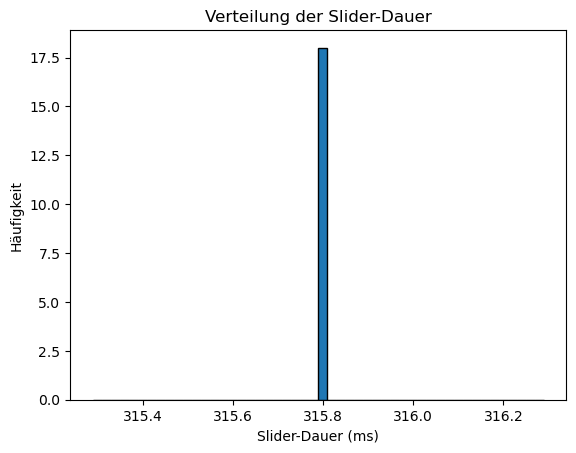

In [24]:
# Beispiel: Histogramm der Slider-Dauer
slider_durations = [tp[2] for tp in data['Timing Points'][0] if tp[3] == 2]  # Annahme: Typ 2 ist Slider
plt.hist(slider_durations, bins=50, edgecolor='black')
plt.title('Verteilung der Slider-Dauer')
plt.xlabel('Slider-Dauer (ms)')
plt.ylabel('Häufigkeit')
plt.show()


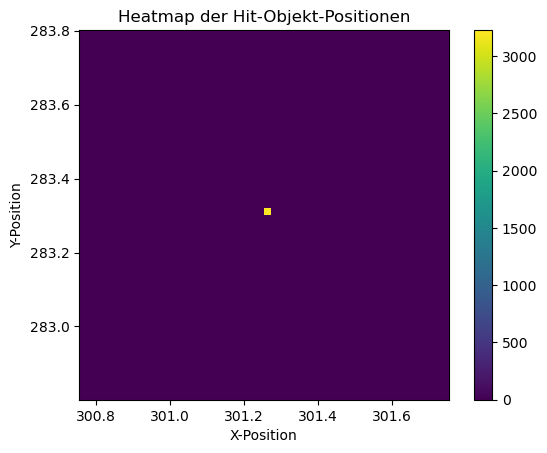

In [25]:
import seaborn as sns

# Beispiel: Heatmap der Hit-Objekt-Positionen
positions = [(256 + 45.254833995939045, 192 + 91.30169768410661) for diff in data['Space Diffs'][0]]
x_positions = [pos[0] for pos in positions]
y_positions = [pos[1] for pos in positions]

heatmap, xedges, yedges = np.histogram2d(x_positions, y_positions, bins=(50, 50))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis')
plt.title('Heatmap der Hit-Objekt-Positionen')
plt.xlabel('X-Position')
plt.ylabel('Y-Position')
plt.colorbar()
plt.show()
